# National-level analysis: Figures 1 & 4

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

plt.rcParams['font.size'] = 14
plt.rcParams['text.usetex'] = False

In [2]:
def get_weather(x):
    return x['gdd']*beta_gdd + x['edd']*beta_edd + x['prcp']*beta_prcp + x['prcp2']*beta_prcp2

In [3]:
coef = pd.read_csv('../../data/yield/regression_coeffs+95.csv', index_col=0)
beta_gdd = coef.loc['gdd']['coeff']
beta_edd = coef.loc['edd']['coeff']
beta_prcp = coef.loc['prcp']['coeff']
beta_prcp2 = coef.loc['prcp2']['coeff']

# Figure 1

In [4]:
# Read in GMFD data
gmfd = pd.read_csv('../../data/yield/GMFD/all_gmfd_historical.csv')
gmfd["fips"] = gmfd["fips"].astype(str).str.zfill(5)
gmfd['prcp2'] = gmfd['prcp']**2
gmfd['weather'] = gmfd.apply(get_weather, axis=1)
gmfd['trend'] = gmfd['log_yield_sim'] - gmfd['weather']

In [5]:
# Read in NEX models
nex_models = !ls ../../data/yield/NEX-GDDP/hist
nex = {model.replace("all_historical_r1i1p1_","").replace(".csv","") : pd.read_csv("../../data/yield/NEX-GDDP/hist/" + model) for model in nex_models}
nex_models = [model.replace("all_historical_r1i1p1_","").replace(".csv","") for model in nex_models]

# NEX yields
nex_yield = pd.DataFrame.from_dict({model : nex[model].set_index(['fips','year'])['yield'] for model in nex_models}).dropna()
nex_yield = nex_yield.reset_index()
nex_yield["fips"] = nex_yield["fips"].astype(str).str.zfill(5)
nex_yield.set_index(['fips','year'], inplace=True)

# NEX weather
for model in nex_models:
    tmp = nex[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['trend'] = tmp['yield'] - tmp['weather']
    nex[model] = tmp

In [6]:
# Read in CMIP models
cmip_models = !ls ../../data/yield/CMIP/hist
cmip = {model.replace("all_","").replace("_historical","").replace(".csv","") : pd.read_csv("../../data/yield/CMIP/hist/" + model) for model in cmip_models}
cmip_models = [model.replace("all_","").replace("_historical","").replace(".csv","") for model in cmip_models]

# CMIP yields
cmip_yield = pd.DataFrame.from_dict({model : cmip[model].set_index(['fips','year'])['yield'] for model in cmip_models}).dropna()
cmip_yield = cmip_yield.reset_index()
cmip_yield["fips"] = cmip_yield["fips"].astype(str).str.zfill(5)
cmip_yield.set_index(['fips','year'], inplace=True)

# CMIP weather
for model in cmip_models:
    tmp = cmip[model]
    tmp['prcp2'] = tmp['prcp']**2
    tmp['weather'] = tmp.apply(get_weather, axis=1)
    tmp['trend'] = tmp['yield'] - tmp['weather']
    cmip[model] = tmp

In [69]:
# Construct national weights (total production by weighted sum of counties) (only 1956-2005)
weights = pd.read_csv('../../data/usda/maize_county_yield_area.csv').filter(["fips", "year", "area","yield"])
weights = weights.query('year >= 1956 and year <= 2005')
weights['fips'] = weights['fips'].astype(str).str.zfill(5)
weights.sort_values(by = ['fips', 'year'], inplace = True)
weights.set_index(['fips', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["fips","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['fips','year']).sort_index()
weights = weights.filter(['national_weight'])

In [70]:
# Yield (weighted by production)

# NEX
nex_weighted = pd.merge(nex_yield.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
for model in nex_weighted.columns[2:-1]:
    nex_weighted[model] = nex_weighted[model] * nex_weighted['national_weight']
nex_weighted = nex_weighted.groupby(['year']).sum()
nex_weighted = nex_weighted.apply(lambda x: x/x['national_weight'], axis=1)
nex_weighted.drop(columns='national_weight', inplace=True)

# CMIP
cmip_weighted = pd.merge(cmip_yield.reset_index(), weights.reset_index(), on = ['fips','year'], how = 'inner')
for model in cmip_weighted.columns[2:-1]:
    cmip_weighted[model] = cmip_weighted[model] * cmip_weighted['national_weight']
cmip_weighted = cmip_weighted.groupby(['year']).sum()
cmip_weighted = cmip_weighted.apply(lambda x: x/x['national_weight'], axis=1)
cmip_weighted.drop(columns='national_weight', inplace=True)

# GMFD
gmfd_weighted = pd.merge(gmfd[['fips','year', 'log_yield_sim', 'trend', 'weather']], weights.reset_index(), on = ['fips','year'], how = 'inner')
gmfd_weighted['log_yield_sim'] = gmfd_weighted['log_yield_sim'] * gmfd_weighted['national_weight']
gmfd_weighted['trend'] = gmfd_weighted['trend'] * gmfd_weighted['national_weight']
gmfd_weighted['weather'] = gmfd_weighted['weather'] * gmfd_weighted['national_weight']
gmfd_weighted = gmfd_weighted.groupby(['year']).sum()
gmfd_weighted = gmfd_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weighted.drop(columns='national_weight', inplace=True)

In [71]:
# Weather & Trend (weighted by production)

# NEX
nex_weather_weighted = {}
for model in nex_models:
    tmp = nex[model].drop(columns='state')
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp = pd.merge(tmp, weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    nex_weather_weighted[model] = tmp
    
# CMIP
cmip_weather_weighted = {}
for model in cmip_models:
    tmp = cmip[model].drop(columns='state')
    tmp['fips'] = tmp['fips'].astype(str).str.zfill(5)
    tmp = pd.merge(tmp, weights.reset_index(), on = ['fips','year'], how = 'inner')
    for col in tmp.columns[2:-1]:
        tmp[col] = tmp[col] * tmp['national_weight']
    tmp = tmp.groupby(['year']).sum()
    tmp = tmp.apply(lambda x: x/x['national_weight'], axis=1)
    tmp.drop(columns='national_weight', inplace=True)
    cmip_weather_weighted[model] = tmp
    
# GMFD
gmfd_weather_weighted = pd.merge(gmfd.drop(columns='state'), weights.reset_index(), on = ['fips','year'], how = 'inner')
for col in gmfd_weather_weighted.columns[2:-1]:
    gmfd_weather_weighted[col] = gmfd_weather_weighted[col] * gmfd_weather_weighted['national_weight']
gmfd_weather_weighted = gmfd_weather_weighted.groupby(['year']).sum()
gmfd_weather_weighted = gmfd_weather_weighted.apply(lambda x: x/x['national_weight'], axis=1)
gmfd_weather_weighted.drop(columns='national_weight', inplace=True)

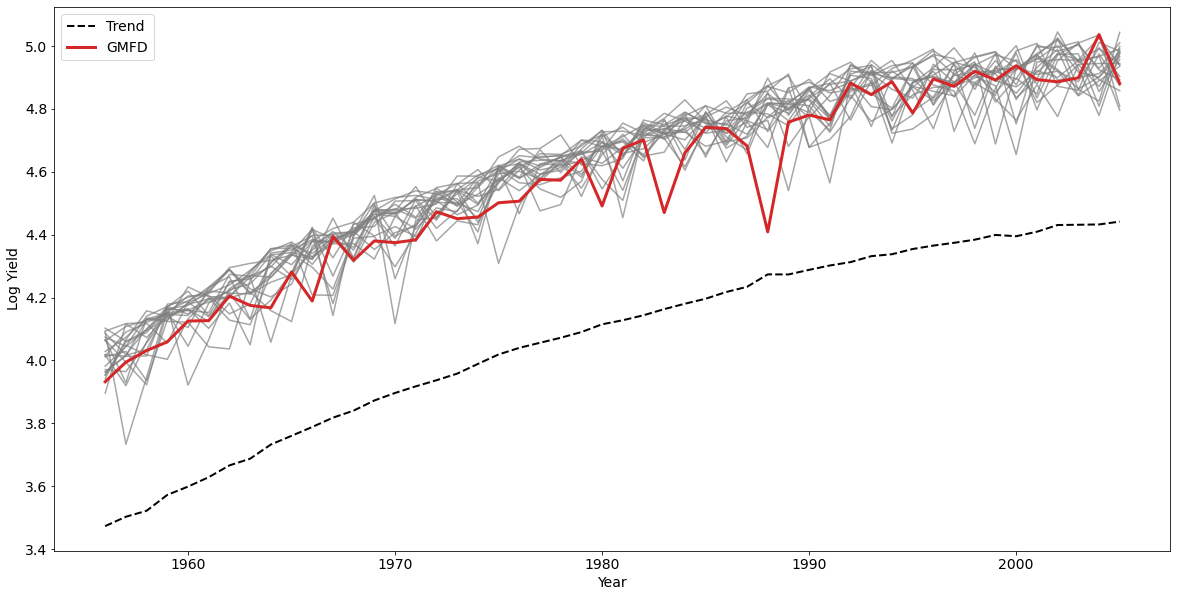

In [77]:
fig, ax = plt.subplots(1,1, figsize=(20,10), sharex=True)

gmfd_weighted.plot(y = 'trend', ax=ax, lw=2, label='Trend', color='black', ls='--')
gmfd_weighted.plot(y = 'log_yield_sim', ax=ax, lw=3, label='GMFD', color='tab:red', zorder=10)
ax.legend()

nex_weighted.plot(ax=ax, color='gray', alpha=0.7, legend=None, zorder=0)
# cmip_weighted.plot(ax=ax, color='gray', alpha=0.7, legend=None)

ax.set_ylabel('Log Yield')
ax.set_xlabel('Year')

plt.savefig('../../figs/new/yield_trend.pdf')

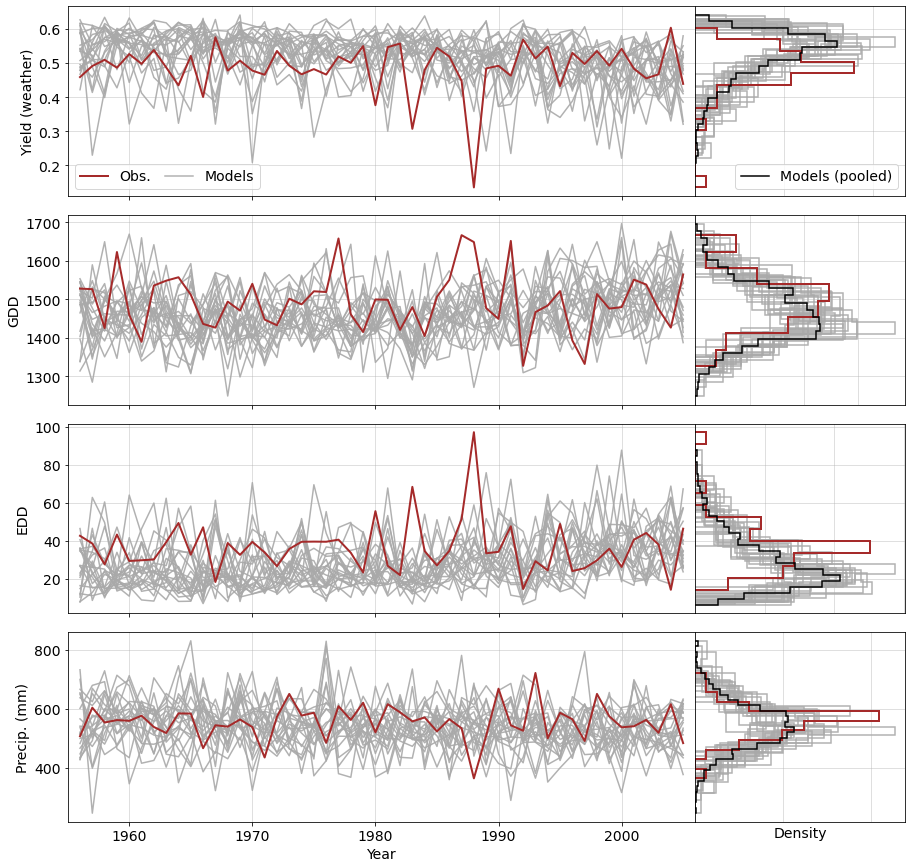

In [164]:
fig, axs = plt.subplots(4,2, figsize=(15,15), sharey='row', gridspec_kw={'width_ratios': [3, 1], 'hspace':0.1, 'wspace':0})
axs=axs.flatten()

###############
# Plot style
###############
model_lw = 1.5
obs_lw = 2
# model_c = '#9ecae1'
model_c = 'darkgray'
obs_c = 'brown'
pooled_c = 'black'
model_alpha = 0.9

############################ 
############## Yield-Weather
############################ 

# Legend
ax=axs[0]
gmfd_weather_weighted.plot(y = 'weather', ax=ax, lw=obs_lw, label='Obs.', color=obs_c, zorder=10)
for model in nex_models[:1]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label='Models')
ax.legend(loc='lower left', ncol=2, columnspacing=1)

# Timeseries
ax=axs[0]
for model in nex_models[1:]:
    ax.plot(nex_weather_weighted[model]['weather'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Yield (weather)')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[1]
for model in nex_models[1:]:
    ax.hist(nex_weather_weighted[model]['weather'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    weather_pooled = np.append(weather_pooled, nex_weather_weighted[model]['weather'].values)
ax.hist(gmfd_weather_weighted['weather'], bins='fd', color=obs_c, histtype='step', lw=obs_lw, label=None, orientation='horizontal', density=True)
ax.hist(weather_pooled, bins='doane', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
# Legend
ax.set_xlim(ax.get_xlim())
ax.set_ylim(ax.get_ylim())
ax.plot([100],[100], color=pooled_c, lw=model_lw, label='Models (pooled)')
ax.legend(loc='lower right')
ax.grid(alpha=0.5)

############################ 
############### GDD
############################ 

# Timeseries
ax=axs[2]
gmfd_weather_weighted.plot(y = 'gdd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['gdd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('GDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[3]
gdd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['gdd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    gdd_pooled = np.append(gdd_pooled, nex_weather_weighted[model]['gdd'].values)
gmfd_weather_weighted['gdd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(gdd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### EDD
############################ 

# Timeseries
ax=axs[4]
gmfd_weather_weighted.plot(y = 'edd', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['edd'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('EDD')
ax.set_xlabel('')
ax.set_xlim([1955,2006])
ax.tick_params(axis='x', which='both', bottom=True, labelbottom=False)
ax.grid(alpha=0.5)

# Hist
ax=axs[5]
edd_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['edd'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    edd_pooled = np.append(edd_pooled, nex_weather_weighted[model]['edd'].values)
gmfd_weather_weighted['edd'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(edd_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.tick_params(axis='both', which='both', left=False, bottom=False, labelbottom=False)
ax.set_xlabel('')
ax.grid(alpha=0.5)

############################ 
############### Precip
############################ 

# Timeseries
ax=axs[6]
gmfd_weather_weighted.plot(y = 'prcp', ax=ax, lw=obs_lw, legend=None, color=obs_c, zorder=10)
for model in nex_models:
    ax.plot(nex_weather_weighted[model]['prcp'], lw=model_lw, color=model_c, alpha=model_alpha, label=None)
ax.set_ylabel('Precip. (mm)')
ax.set_xlabel('Year')
ax.set_xlim([1955,2006])
ax.grid(alpha=0.5)

# Hist
ax=axs[7]
prcp_pooled = np.array([])
for model in nex_models:
    ax.hist(nex_weather_weighted[model]['prcp'], lw=model_lw, bins='fd', color=model_c, alpha=model_alpha, label=None, histtype='step', orientation='horizontal', density=True)
    prcp_pooled = np.append(prcp_pooled, nex_weather_weighted[model]['prcp'].values)
gmfd_weather_weighted['prcp'].plot(kind='hist', bins='fd', color=obs_c, histtype='step', ax=ax, lw=obs_lw, legend=None, orientation='horizontal', density=True)
ax.hist(prcp_pooled, bins='fd', color=pooled_c, histtype='step', lw=model_lw, label=None, orientation='horizontal', density=True)
ax.set_xlabel('Density')
ax.tick_params(axis='y', which='both', left=False)
ax.tick_params(axis='x', which='both', bottom=False, labelbottom=False)
ax.grid(alpha=0.5)

# Plot
# plt.show()
plt.savefig('../../figs/new/annual_all.pdf')

## Figure 4

In [21]:
# Get both ensembles
from combine import combine_nex_yield, combine_cmip_yield

nex_mid = combine_nex_yield(hist=False, mid=True)
cmip_mid = combine_cmip_yield(hist=False, mid=True)

nex_end = combine_nex_yield(hist=False, end=True)
cmip_end = combine_cmip_yield(hist=False, end=True)

In [22]:
# Construct national weights (total production by weighted sum of counties)
weights = pd.read_csv('../usda/output/USDA_county_yields_w_county_quad_trends.csv').filter(["GEOID", "year", "area","yield"])
weights["GEOID"] = weights["GEOID"].astype(str).str.zfill(5)
weights.sort_values(by = ['GEOID', 'year'], inplace = True)
weights.set_index(['GEOID', 'year'], inplace = True)
weights["national_weight"] = weights["area"] * weights["yield"]
weights_norm = weights.groupby("year").sum().drop(columns = ["yield", "area"])
# Normalise
weights = pd.merge(weights.reset_index().filter(["GEOID","year","national_weight"]), weights_norm, on = "year")
weights["national_weight"] = weights["national_weight_x"] / weights["national_weight_y"]
weights.drop(columns = ["national_weight_x", "national_weight_y"],inplace=True)
weights = weights.set_index(['GEOID','year']).sort_index()
weights = weights.filter(['national_weight'])

# Take mean for projections
weights = weights.mean(level = 'GEOID')

In [23]:
# Interquartile range
def get_iqr(dat):
    return np.quantile(dat, 0.75) - np.quantile(dat, 0.25)

# Silverman bandwidth estimate
def silverman(dat):
    return 0.9 * np.min([np.std(dat), get_iqr(dat)/1.34]) * len(dat)**-0.2

In [24]:
##################################################################################################
include_p05 = False ################# If True, only counties with F-test p-value < 0.05 are included
include_loo = True ################# If True, only counties with LOO CV improvement are included
if include_p05:
    p05_counties = pd.read_csv('../ag_model/fit_model/ag_model_coeff_final.csv').query('pval < 0.05')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
elif include_loo:
    p05_counties = pd.read_csv('../ag_model/fit_model/loo_yes.csv')['GEOID'].astype(str).str.zfill(5).unique()
    weights = weights.loc[p05_counties]
##################################################################################################

# Yield (weighted by production)
nex_mid_weighted = pd.merge(nex_mid.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in nex_mid_weighted.columns[2:-1]:
    nex_mid_weighted[model] = nex_mid_weighted[model] * nex_mid_weighted['national_weight']
nex_mid_weighted = nex_mid_weighted.groupby(['Year']).sum()

cmip_mid_weighted = pd.merge(cmip_mid.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in cmip_mid_weighted.columns[2:-1]:
    cmip_mid_weighted[model] = cmip_mid_weighted[model] * cmip_mid_weighted['national_weight']
cmip_mid_weighted = cmip_mid_weighted.groupby(['Year']).sum()

nex_end_weighted = pd.merge(nex_end.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in nex_end_weighted.columns[2:-1]:
    nex_end_weighted[model] = nex_end_weighted[model] * nex_end_weighted['national_weight']
nex_end_weighted = nex_end_weighted.groupby(['Year']).sum()

cmip_end_weighted = pd.merge(cmip_end.reset_index(), weights.reset_index(), on = ['GEOID'], how = 'inner')
for model in cmip_end_weighted.columns[2:-1]:
    cmip_end_weighted[model] = cmip_end_weighted[model] * cmip_end_weighted['national_weight']
cmip_end_weighted = cmip_end_weighted.groupby(['Year']).sum()

# Ensembles
NEXens_mid_w = nex_mid_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
CMIPens_mid_w = cmip_mid_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
NEXens_end_w = nex_end_weighted.drop(columns = ['national_weight']).to_numpy().flatten()
CMIPens_end_w = cmip_end_weighted.drop(columns = ['national_weight']).to_numpy().flatten()

In [25]:
%%time
# Construct CDFs
nexmidgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_mid_w), 3*silverman(NEXens_mid_w), 30)})
cmipmidgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_mid_w), 3*silverman(CMIPens_mid_w), 30)})
nexendgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(NEXens_end_w), 3*silverman(NEXens_end_w), 30)})
cmipendgrid = GridSearchCV(KernelDensity(), {'bandwidth': np.linspace(0.5*silverman(CMIPens_end_w), 3*silverman(NEXens_end_w), 30)})

nexmidgrid.fit(NEXens_mid_w[:, None])
cmipmidgrid.fit(CMIPens_mid_w[:, None])
nexendgrid.fit(NEXens_end_w[:, None])
cmipendgrid.fit(CMIPens_end_w[:, None])

print(nexmidgrid.best_params_['bandwidth'])
print(cmipmidgrid.best_params_['bandwidth'])
print(nexendgrid.best_params_['bandwidth'])
print(cmipendgrid.best_params_['bandwidth'])

NEX_ens_mid_pdf = KernelDensity(bandwidth=nexmidgrid.best_params_['bandwidth'])
NEX_ens_mid_pdf.fit(NEXens_mid_w[:, np.newaxis]);
CMIP_ens_mid_pdf = KernelDensity(bandwidth=cmipmidgrid.best_params_['bandwidth'])
CMIP_ens_mid_pdf.fit(CMIPens_mid_w[:, np.newaxis]);
NEX_ens_end_pdf = KernelDensity(bandwidth=nexendgrid.best_params_['bandwidth'])
NEX_ens_end_pdf.fit(NEXens_end_w[:, np.newaxis]);
CMIP_ens_end_pdf = KernelDensity(bandwidth=cmipendgrid.best_params_['bandwidth'])
CMIP_ens_end_pdf.fit(CMIPens_end_w[:, np.newaxis]);

0.09156052542919565
0.08150078228433406
0.13206744314259064
0.1488975139244788
CPU times: user 1.19 s, sys: 7.12 ms, total: 1.2 s
Wall time: 1.2 s


KernelDensity(bandwidth=0.1488975139244788)

In [26]:
# Get return periods
logyields = [i for i in np.linspace(-0.6,0,50)]
NEXr_mid = []
NEXr_end = []
CMIPr_mid = []
CMIPr_end = []
for logyield in logyields:
    xgrid = np.linspace(-10,logyield,1000)
    nexr_mid = 1/integrate.trapz(np.exp(NEX_ens_mid_pdf.score_samples(xgrid[:,None])), xgrid)
    nexr_end = 1/integrate.trapz(np.exp(NEX_ens_end_pdf.score_samples(xgrid[:,None])), xgrid)
    cmipr_mid = 1/integrate.trapz(np.exp(CMIP_ens_mid_pdf.score_samples(xgrid[:,None])), xgrid)
    cmipr_end = 1/integrate.trapz(np.exp(CMIP_ens_end_pdf.score_samples(xgrid[:,None])), xgrid)
    
    NEXr_mid.append(nexr_mid)
    NEXr_end.append(nexr_end)
    CMIPr_mid.append(cmipr_mid)
    CMIPr_end.append(cmipr_end)

In [27]:
# Largest yield shock
GMFDens_w.min()

-0.28757724332232504

In [28]:
# Closest value
logyields[-25]

-0.29387755102040813

In [29]:
# Projected return periods
[NEXr_mid[-25],NEXr_end[-25],CMIPr_mid[-25],CMIPr_end[-25]]

[15.982981491835512, 6.7013332898907825, 6.451760115672035, 4.5646934772537495]

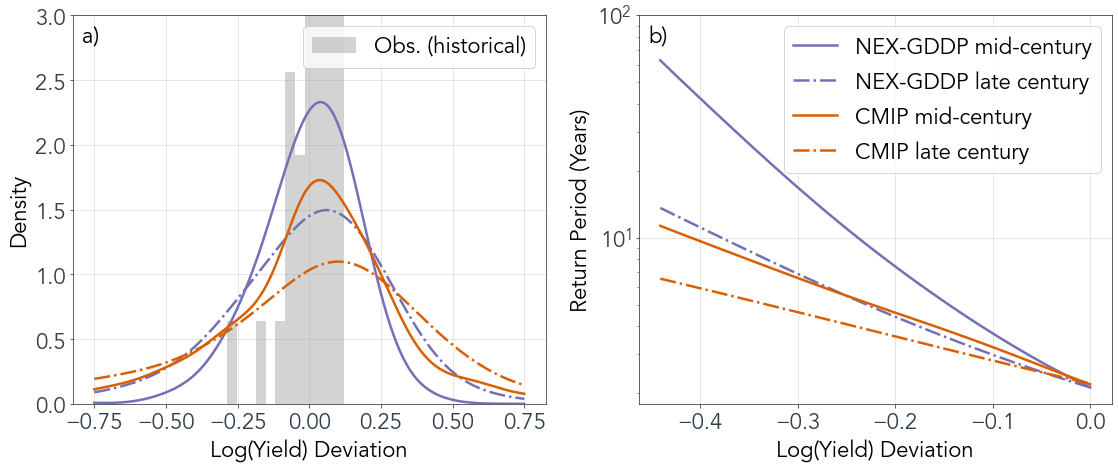

In [30]:
# Plot all
fig, axs = plt.subplots(1,2,figsize = (16,7))
plt.rcParams['font.size'] = 22

# Distributions
ax = axs[0]
xarr = np.linspace(-0.75,0.75,1000)
ax.plot(xarr, np.exp(NEX_ens_mid_pdf.score_samples(xarr[:,None])), color = '#7570b3', linewidth=2.5)
ax.plot(xarr, np.exp(NEX_ens_end_pdf.score_samples(xarr[:,None])), color = '#7570b3', linewidth=2.5, linestyle='dashdot' )

ax.plot(xarr, np.exp(CMIP_ens_mid_pdf.score_samples(xarr[:,None])), color = '#d95f02', linewidth=2.5)
ax.plot(xarr, np.exp(CMIP_ens_end_pdf.score_samples(xarr[:,None])), color = '#d95f02', linewidth=2.5, linestyle='dashdot')

ax.hist(GMFDens_w, label = 'Obs. (historical)', color = 'darkgray', density=True, alpha = 0.5, bins='fd')
ax.set_ylim([0,3])

ax.legend(loc = 'upper right')
ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Density')
ax.grid(zorder=10, alpha=0.4)
ax.text(0.02, 0.93, 'a)', transform=ax.transAxes)

# Return Periods
ax=axs[1]
n=13
ax.plot(logyields[n:], NEXr_mid[n:], label = 'NEX-GDDP mid-century', color = '#7570b3', linewidth=2.5)
ax.plot(logyields[n:], NEXr_end[n:], label = 'NEX-GDDP late century', color = '#7570b3', linewidth=2.5, linestyle='dashdot' )

ax.plot(logyields[n:], CMIPr_mid[n:], label = 'CMIP mid-century', color = '#d95f02', linewidth=2.5)
ax.plot(logyields[n:], CMIPr_end[n:], label = 'CMIP late century', color = '#d95f02', linewidth=2.5, linestyle='dashdot')

ax.legend()
ax.set_xlabel('Log(Yield) Deviation')
ax.set_ylabel('Return Period (Years)')
ax.set_yscale('log')
ax.set_yticks([10, 100])
ax.grid(zorder=10, alpha=0.4)
ax.text(0.02, 0.93, 'b)', transform=ax.transAxes)

plt.tight_layout()
# plt.show()
plt.savefig('../figs/figure4.pdf')